### Задание

Проведите полный цикл работы над вашим проектом, что проходили ранее. Pipeline выполнения задачи:

1. Загрузка и предобработка данных 

2. Описательный анализ данных, просмотр данных и вывод статистики

3. Постройте необходимые графики для анализа

4. Проверьте гипотезы (если потребуется)

5. Сделайте промежуточный отчет-вывод по исследованию

6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

9. Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

10. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

### Рекомендации:

1. Соблюдайте PEP8

2. Комментируйте код в местах, где конструкция большая

3. Оставляйте промежуточные выводы по вашему исследованию и построению модели (так кураторам будет проще понять ваши заключения)

4. Экспериментируйте! Вы не ограничены в моделях и подходах. Можете использовать любые DS инструменты (и те, которые мы не разбирали с вами на курсе)

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [84]:
# Загрузка и вывод данных
df = pd.read_csv('gender_classification_v7.csv')
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


In [85]:
# Кодирование категориальных данных целевого столбца
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 312.7 KB


- В таблице 5001 запись
- 7 признаков
- Все данные в числовом формате.
- Пропусков нет


In [87]:
df.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.00000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900,0.49990
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049,0.50005
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000,0.00000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000,1.00000


- Данные в таблице распределены равномерно. Аномальных значений не наблюдается.
- Количество людей с длинными волосами составляет почти 87% исследуемых.
- Минимальное значение ширины лба 11.4 см, максимальное - 15.5 см.
- Минимальное значение высоты лба 5.1 см, максимальное - 7.1 см.

In [88]:
df.duplicated().sum()

1768

В таблице 1768 дубликатов. Удалим их.

In [89]:
df.drop_duplicates(inplace=True)

array([[<Axes: title={'center': 'long_hair'}>,
        <Axes: title={'center': 'forehead_width_cm'}>,
        <Axes: title={'center': 'forehead_height_cm'}>],
       [<Axes: title={'center': 'nose_wide'}>,
        <Axes: title={'center': 'nose_long'}>,
        <Axes: title={'center': 'lips_thin'}>],
       [<Axes: title={'center': 'distance_nose_to_lip_long'}>,
        <Axes: title={'center': 'gender'}>, <Axes: >]], dtype=object)

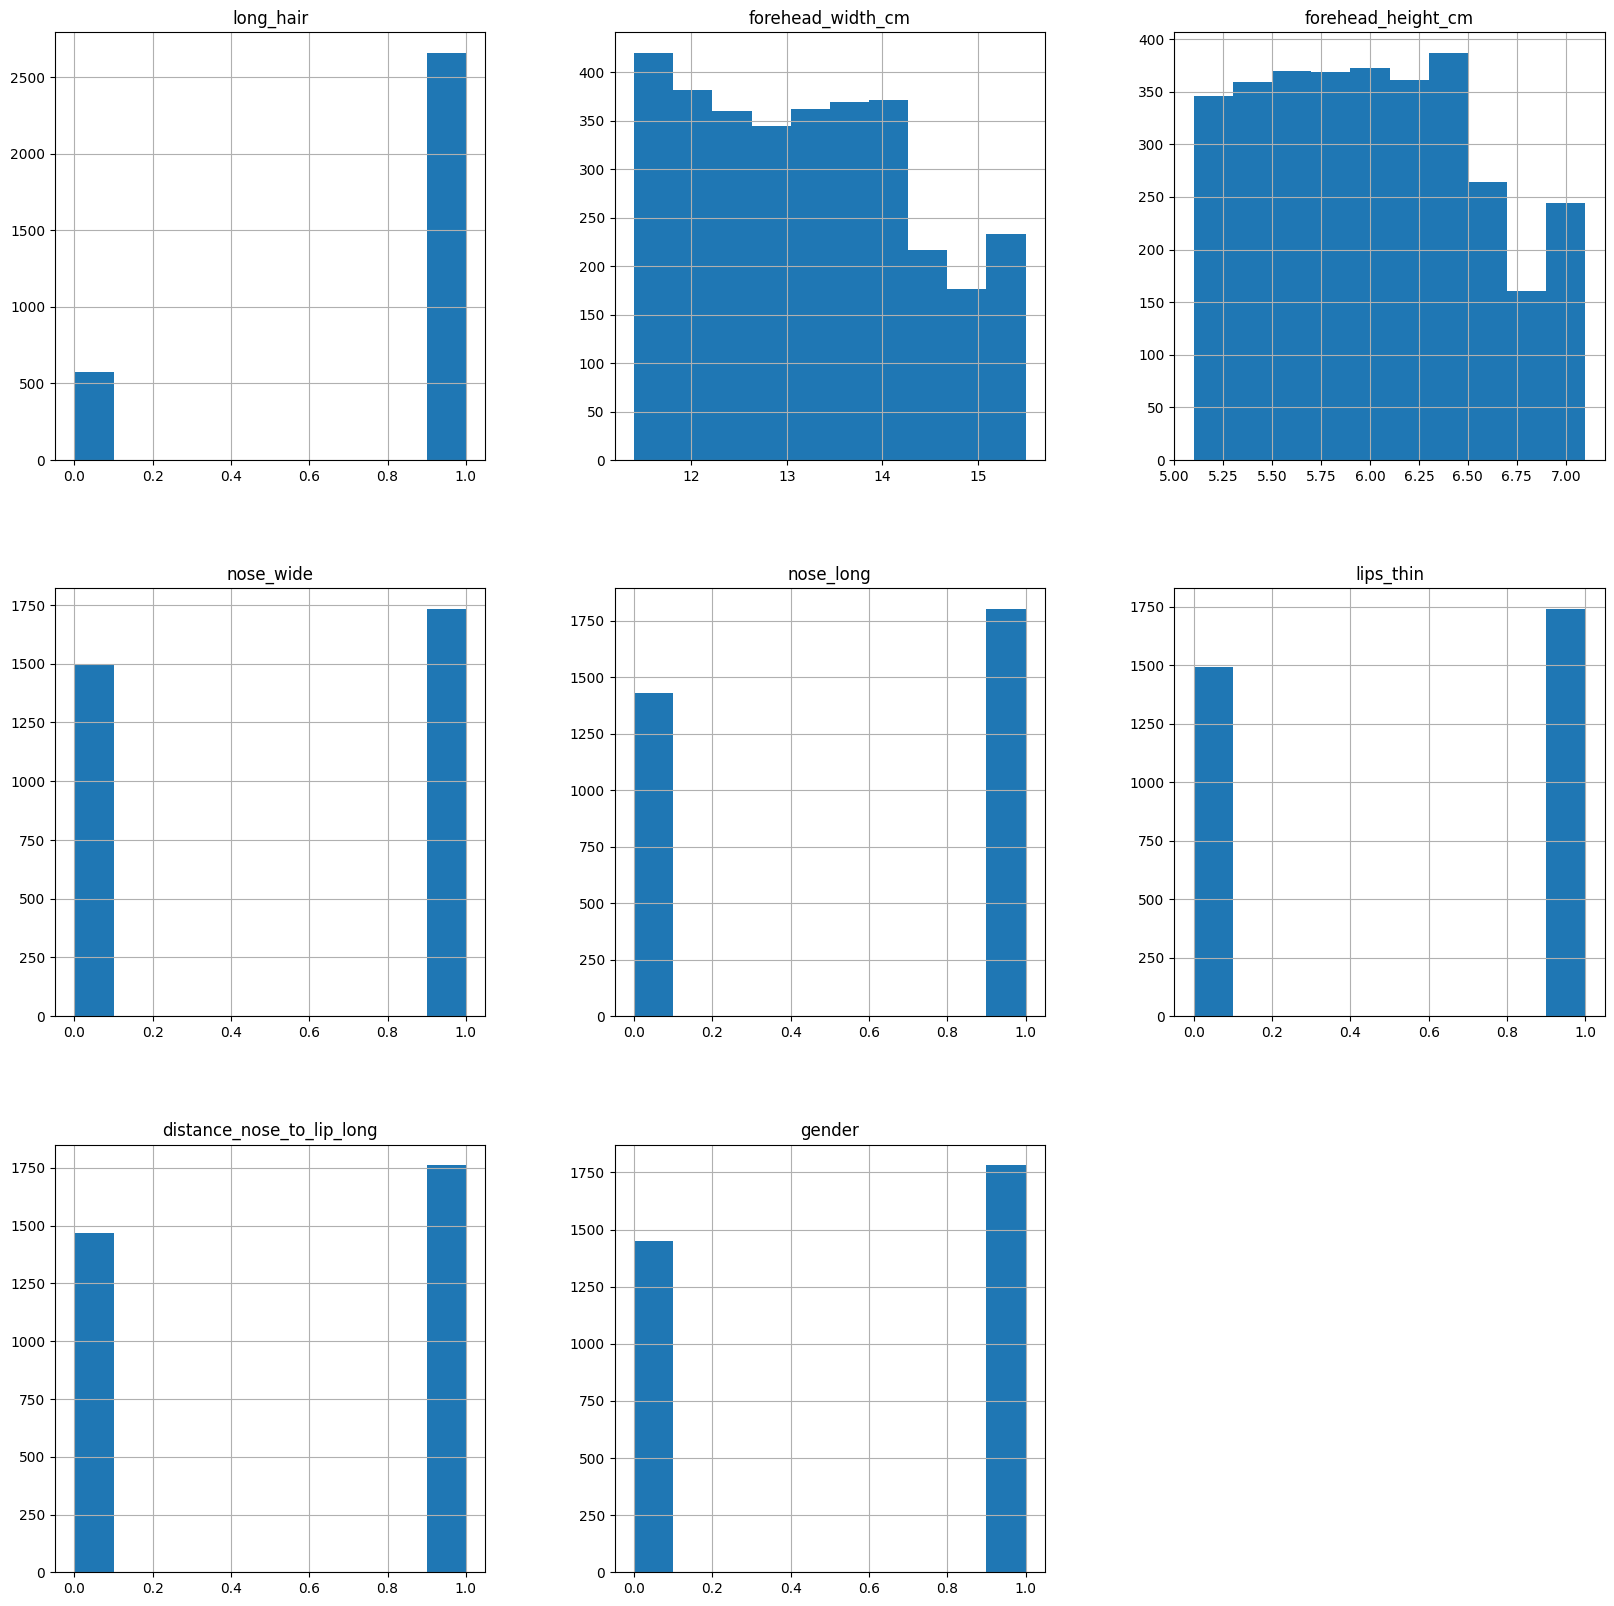

In [90]:
df.hist(figsize=(20,20))

<Axes: >

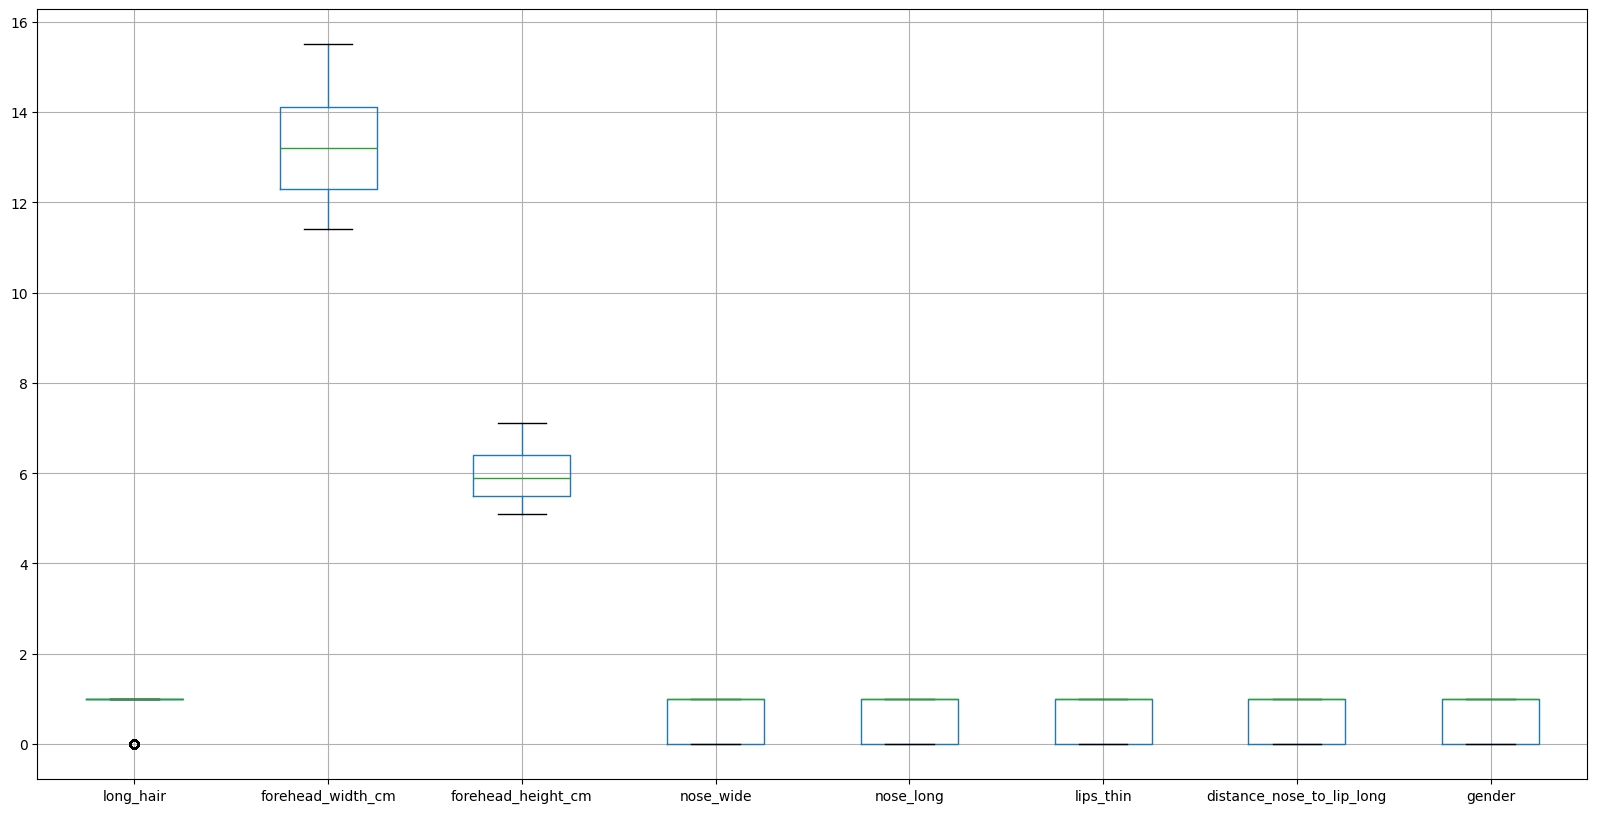

In [91]:
df.boxplot(figsize=(20,10))

Графики подтверждают отсутствие выбросов.

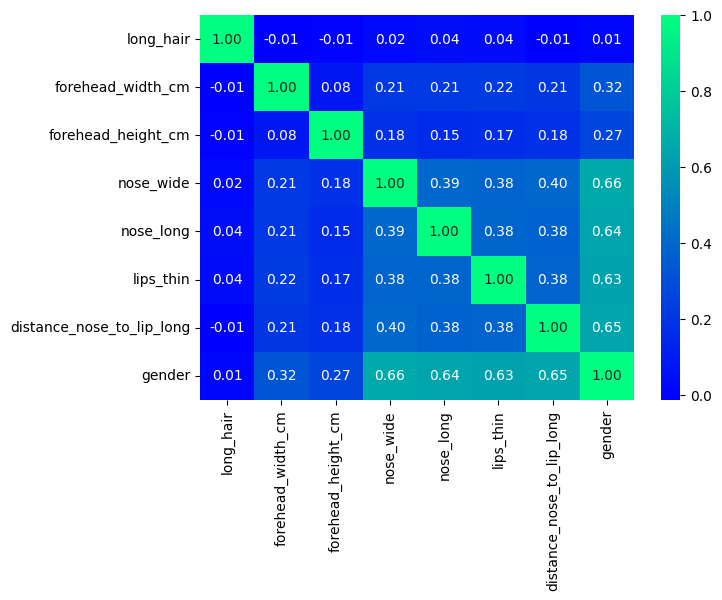

In [92]:
# Корреляционная матрица
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='winter')
plt.show()

Из корреляционной матрицы видно:
1. с целевой переменной хорошо коррелируют следующие характеристики
- nose_wide - 0.66
- distance_nose_to_lip_long - 0.65
- nose_long - 0.64
- lips_thin - 0.63
2. Также в меньшей степени корреляцию показывают признаки:
- forehead_width_cm	 - 0,32
- forehead_height_cm - 0,27
3. наименьшее влияние на целевую переменную оказывает длина волос (0.01)

Проверим гипотезу:

- H0 - средние/медианные показатели между мужчинами и женщинами отличаются
- H1 - средние/медианные показатели между мужчинами и женщинами не отличаются

Сравним две выборки

In [93]:
# Выборка мужчин
df_male = df.loc[df.gender == 1].drop('gender', axis=1)
df_male.head().T

,0,2,3,5,6
long_hair,1.0,0.0,0.0,1.0,1.0
forehead_width_cm,11.8,11.8,14.4,13.0,15.3
forehead_height_cm,6.1,6.3,6.1,6.8,6.2
nose_wide,1.0,1.0,0.0,1.0,1.0
nose_long,0.0,1.0,1.0,1.0,1.0
lips_thin,1.0,1.0,1.0,1.0,1.0
distance_nose_to_lip_long,1.0,1.0,1.0,1.0,0.0


In [94]:
# Выборка женщин
df_female = df.loc[df.gender == 0].drop('gender', axis=1)
df_female.head().T

,1,4,7,8,9
long_hair,0.0,1.0,0.0,1.0,1.0
forehead_width_cm,14.0,13.5,13.0,11.9,12.1
forehead_height_cm,5.4,5.9,5.2,5.4,5.4
nose_wide,0.0,0.0,0.0,1.0,0.0
nose_long,0.0,0.0,0.0,0.0,0.0
lips_thin,1.0,0.0,0.0,1.0,0.0
distance_nose_to_lip_long,0.0,0.0,0.0,1.0,0.0


In [95]:
for col in df.drop('gender', axis=1):
    _, pvalue = stats.ttest_ind(df_male[col], df_female[col])

    alpha = 0.05

    if pvalue < alpha:
        print(f'{col}: P-value: {pvalue:.5f}. Отвергаем нулевую гипотезу: средние различаются.')
    else:
        print(f'{col}: P-value: {pvalue:.5f}. Не отвергаем нулевую гипотезу: средние не различаются.')

long_hair: P-value: 0.42837. Не отвергаем нулевую гипотезу: средние не различаются.
forehead_width_cm: P-value: 0.00000. Отвергаем нулевую гипотезу: средние различаются.
forehead_height_cm: P-value: 0.00000. Отвергаем нулевую гипотезу: средние различаются.
nose_wide: P-value: 0.00000. Отвергаем нулевую гипотезу: средние различаются.
nose_long: P-value: 0.00000. Отвергаем нулевую гипотезу: средние различаются.
lips_thin: P-value: 0.00000. Отвергаем нулевую гипотезу: средние различаются.
distance_nose_to_lip_long: P-value: 0.00000. Отвергаем нулевую гипотезу: средние различаются.


Как видно из проверки гипотезы, средние всех признаков двух выборок, кроме 'long_hair', различаются. Т.е. наблюдается определенная зависимость между внешностью человека и его полом, что и подтверждает приведенная выше матрица корреляции.

In [96]:
# отделение целевой переменной от признаков
X = df.drop('gender', axis=1)
y = df['gender']

In [97]:
y.value_counts()

gender
1    1783
0    1450
Name: count, dtype: int64

Классы сбалансированы плохо

In [98]:
# Получим веса классов для дальнейшего использования в модели
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights

array([1.11482759, 0.90661806])

In [99]:
# Разделение данных на тренировочную, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12)

In [100]:
# Масштабирование признаков
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

Будем решать задачу классификации. для оценки моделей будем использовать метрику ROC-AUC, т.к. классы плохо сбалансированы.

1. Модель логистической регрессии

In [101]:
model_log_reg = LogisticRegression(class_weight='balanced', max_iter=200)
model_log_reg.fit(X_train, y_train)
roc_auc_score(y_val, model_log_reg.predict(X_val))

0.9344626492640934

2. Модель дерева решений

In [102]:
model_rf = DecisionTreeClassifier(class_weight='balanced')
model_rf.fit(X_train, y_train)
roc_auc_score(y_val, model_rf.predict(X_val))

0.9320588031102471

3. Модель случайного леса

In [103]:
model_rf = RandomForestClassifier(random_state=12, class_weight='balanced', max_depth=10, min_samples_leaf=4, min_samples_split=40, n_estimators=200)
model_rf.fit(X_train, y_train)
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:, 1])

0.99185990002777

4. Модель полносвязной нейронной сети

In [104]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['auc'])
    
    return model

model_nn = create_model()

monitor = 'val_auc'
early_stopping = EarlyStopping(monitor=monitor, mode='max', patience=10, restore_best_weights=True)
save_best_weights = ModelCheckpoint(filepath='.weights.h5',
                                    save_weights_only=True,
                                    monitor=monitor,
                                    mode='max',
                                    save_best_only=True)

history = model_nn.fit(X_train, y_train.to_numpy(),
                    validation_data=(X_val, y_val.to_numpy()), 
                    epochs=50,
                    batch_size=32, 
                    class_weight={0:class_weights[0], 1:class_weights[1]},
                    callbacks=[early_stopping, save_best_weights])

print(f'ROC AUC на валидационной части: {model_nn.evaluate(X_val, y_val.to_numpy(), verbose=0)[1]}')

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.8715 - loss: 0.4306 - val_auc: 0.9880 - val_loss: 0.2345
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9569 - loss: 0.2655 - val_auc: 0.9880 - val_loss: 0.1884
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9646 - loss: 0.2440 - val_auc: 0.9880 - val_loss: 0.1634
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9546 - loss: 0.2802 - val_auc: 0.9886 - val_loss: 0.1617
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9573 - loss: 0.2645 - val_auc: 0.9880 - val_loss: 0.1601
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9661 - loss: 0.2360 - val_auc: 0.9887 - val_loss: 0.1588
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9640 - loss: 0.2472 - val_auc: 0.9896 - val_loss: 0.1566
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9544 - loss: 0.2775 - val_auc: 0.9895 - val_loss: 0.1516
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9625 - loss: 

Лучшая модель - случайный лес (ROC-AUC = 0.99185990002777)

In [107]:
# Оценка на тестовой выборке
roc_auc_score(y_test, model_rf.predict(X_test))

0.9741464833059661

Сравним полученные результаты с предсказанием простейшей dummy-модели на основе стратегии наиболее часто встречающегося класса из обучающей выборки.

In [106]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
roc_auc_score(y_val, dummy_clf.predict_proba(X_val)[:, 1])

0.5

### Вывод:

В результате исследования были построены следующие модели с метрикой ROC-AUC на валидационной выборке:

- логистическая регрессия - 0.9344626492640934
- дерево решений - 0.9320588031102471
- случайный лес - 0.99185990002777
- полносвязная нейронная сеть - 0.9899507164955139


Как видно из таблицы, все модели продемонстрировали хорошую точность. Но наилучшей оказалась *модель случайного леса*.

ROC-AUC на тестовой выборке данной модели составил 0.9741464833059661.

Сравнение созданных моделей с предсказаниями простой dummy-модели позволяет сделать вывод, что машинное обучение является более подходящим выбором, т.к. метрика ROC-AUC dummy-предсказания равно 0.5, а это сравнимо с ROC-AUC случайной модели.